Running regime: Easy
Running regime: Moderate
Running regime: Strict

================ LaTeX Table: Continuous-time MC Summary ================

\begin{table}[H]
\centering
\small
\caption{continuous-time monte carlo outcomes (means with 95\% confidence interval over $R=%d$ replications).}
\label{tab:ct_mc_summary_generated}
\setlength{\tabcolsep}{5pt}
\renewcommand{\arraystretch}{1.2}
\begin{tabular}{@{}lccccc@{}}
\textbf{Regime} & $I_{\max}$ & $t(I_{\max})$ & Attack rate & $V(T)$ & $\overline{I}$ \\
\hline
Easy & 0.154 [0.153, 0.154] & 43.8 [43.3, 44.3] & 0.67 [0.67, 0.67] & 0.31 [0.31, 0.31] & 0.027 [0.027, 0.027] \\
Moderate & 0.106 [0.106, 0.106] & 54.1 [53.4, 54.8] & 0.59 [0.59, 0.59] & 0.40 [0.40, 0.40] & 0.023 [0.023, 0.023] \\
Strict & 0.008 [0.008, 0.009] & 34.2 [33.9, 34.6] & 0.04 [0.04, 0.04] & 0.95 [0.95, 0.95] & 0.002 [0.002, 0.002] \\
\hline
\end{tabular}
\end{table}


================ LaTeX Table: Behavioral Sensitivity & Subsidy ================

\begin{table}[H]
\cent

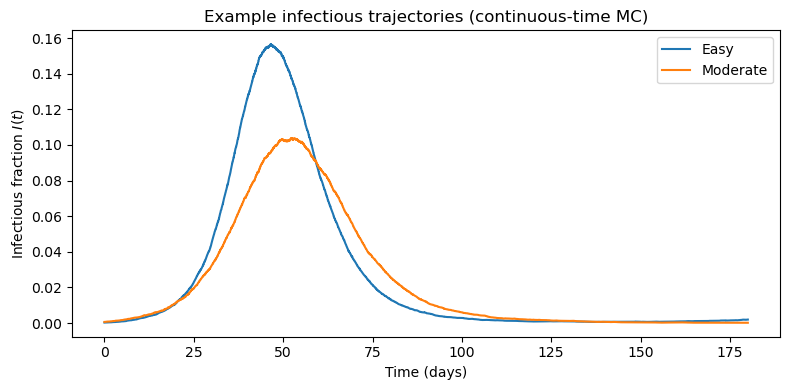

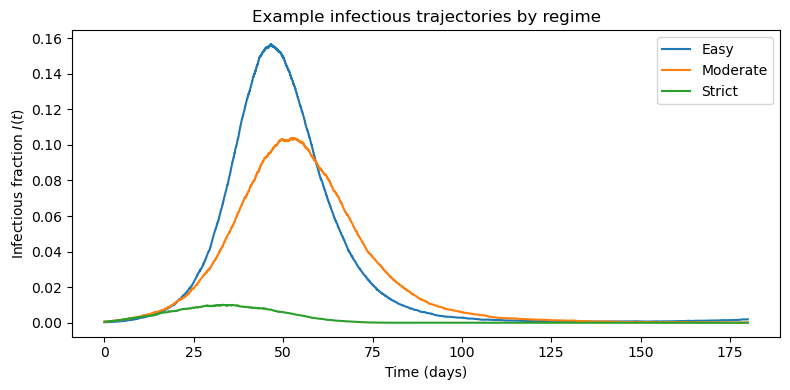

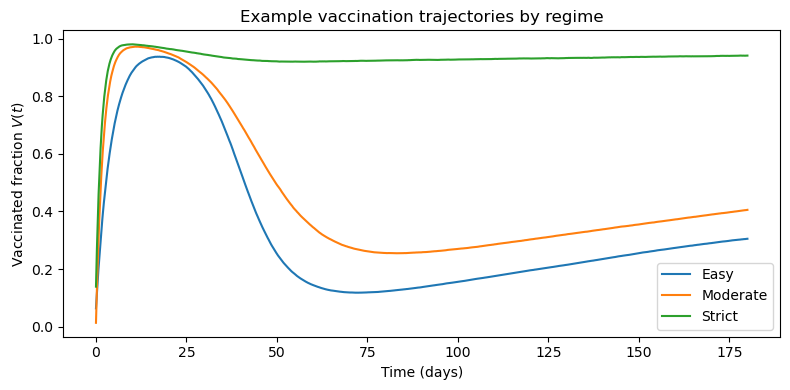

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Experiment 1: Continuous-time Monte Carlo (SVEIR + behavior)
# ============================================================

# -------------------------
# Global simulation settings
# -------------------------

T = 180.0          # horizon (days)
dt = 1e-2          # time step (days)
R = 200            # number of Monte Carlo replications per regime
N = 100_000        # population size (for stochastic events)

rng = np.random.default_rng(seed=12345)  # for reproducibility

# -------------------------
# Epidemiological parameters
# -------------------------

beta0 = 0.9        # baseline transmission/contact rate
kappa_E = 0.33     # E -> I progression
gamma = 0.20       # I -> R recovery
delta = 1.0 / 180  # waning of vaccine immunity
omega = 1.0 / 365  # waning of natural immunity
mu = 1e-4          # natural mortality (small)
eta_E = 0.2        # mixing modifier for exposed

# Vaccine effects
eps_s = 0.6        # vaccination reduces susceptibility (S->E hazard)
eps_d = 0.6        # vaccination reduces severity / cost of infection

# -------------------------
# Behavioral parameters (baseline)
# -------------------------

rho = 1.0          # behavioral update rate in psi(t)
K = 0.5            # Fermi noise in psi(t)
kappa_payoff = 0.10  # learning rate in dU/dt

# Payoff scales
cV_baseline = 0.6  # baseline vaccination cost
C_I = 1.0          # infection cost intensity
h_herd = 0.2       # modest herd-protection bonus from vaccination coverage
b_baseline = 0.0   # baseline social payoff

# -------------------------
# Regimes (easy / moderate / strict)
# -------------------------

REGIMES = {
    "Easy": {
        "alpha": 0.10,
        "sigma": 0.0,
    },
    "Moderate": {
        "alpha": 0.25,
        "sigma": 0.6,
    },
    "Strict": {
        "alpha": 0.50,
        "sigma": 0.9,
    },
}

# ============================================================
# Payoff builder and behavioral couplings (tightened)
# ============================================================

def payoff_SV(S_frac, V_frac, E_frac, I_frac, beta_t, params):
    """
    Mean-field payoff builder for susceptible (S-strategy) and vaccinated (V-strategy) agents.

    - Infection hazard for S: λ_S = β(t) * (I + η_E * E)
    - Infection hazard for V: λ_V = (1 - eps_s) * λ_S
    - Infection cost severity: C_I for S, (1 - eps_d) * C_I for V
    - Vaccination cost: cV_eff = cV_baseline - σ
    - Herd protection: bonus proportional to V_frac (h_herd * V_frac)

    Returns (pi_S, pi_V).
    """
    sigma = params["sigma"]

    # Effective infection hazard (per day) for S:
    lambda_S = beta_t * (I_frac + eta_E * E_frac)
    lambda_V = (1.0 - eps_s) * lambda_S

    # Effective vaccination cost (subsidy reduces cost)
    cV_eff = cV_baseline - sigma

    # Infection cost
    cost_inf_S = C_I * lambda_S
    cost_inf_V = (1.0 - eps_d) * C_I * lambda_V

    # Herd protection benefit
    herd_bonus = h_herd * V_frac

    # Payoffs (higher is better)
    pi_S = b_baseline + herd_bonus - cost_inf_S
    pi_V = b_baseline + herd_bonus - cV_eff - cost_inf_V

    return pi_S, pi_V


def update_beta(U_S, U_V, params):
    """
    β(t) = β0 * [1 - α * (U_V - U_S)], clamped to non-negative.
    """
    alpha = params["alpha"]
    delta_U = U_V - U_S
    beta_t = beta0 * (1.0 - alpha * delta_U)
    return max(0.0, beta_t)


def update_psi(pi_S, pi_V, params):
    """
    ψ(t) = ρ / (1 + exp(-(π_V - π_S)/K)).
    """
    delta_pi = pi_V - pi_S
    return rho * (1.0 / (1.0 + np.exp(-delta_pi / K)))


def approximate_R0_eff0(params):
    """
    Approximate R0^{eff}(0) at the DFE using the tightened payoff structure.

    At DFE: E=I=0, V≈0 => risk = 0.
    Then λ_S = λ_V = 0, so infection cost is zero; herd_bonus ≈ h_herd * 0 = 0.

    Payoffs:
      π_S = 0
      π_V = -cV_eff = -(cV_baseline - σ)
    Set U_i ≈ π_i at DFE to compute β_eff and then standard R0.
    """
    sigma = params["sigma"]

    pi_S = 0.0
    pi_V = -(cV_baseline - sigma)
    U_S = pi_S
    U_V = pi_V

    beta_eff = update_beta(U_S, U_V, params)

    # SEIR-like approximation including η_E:
    R0_eff = beta_eff * (1.0 + eta_E) * kappa_E / ((kappa_E + mu) * (gamma + mu))
    return R0_eff

# ============================================================
# Single-regime Monte Carlo simulation
# ============================================================

def simulate_regime(regime_name, regime_params, R=200, dt=1e-2, T=180.0, N=100_000):
    """
    Simulate the SVEIR + behavior system for a given regime over R replications.
    Returns summary metrics and one example trajectory for plotting.
    """

    n_steps = int(T / dt) + 1
    time_grid = np.linspace(0.0, T, n_steps)

    # Metrics arrays
    I_max_arr = np.zeros(R)
    t_I_max_arr = np.zeros(R)
    attack_rate_arr = np.zeros(R)
    V_T_arr = np.zeros(R)
    I_mean_arr = np.zeros(R)

    # For plotting: store one example I(t), V(t)
    I_traj_example = None
    V_traj_example = None

    for r in range(R):
        # --- Initial conditions (counts) ---
        I0_frac = rng.uniform(1e-4, 1e-3)
        E0_frac = I0_frac
        V0_frac = rng.uniform(0.0, 0.2)
        R0_frac = 0.0
        S0_frac = 1.0 - (I0_frac + E0_frac + V0_frac + R0_frac)

        S = int(round(S0_frac * N))
        V = int(round(V0_frac * N))
        E = int(round(E0_frac * N))
        I = int(round(I0_frac * N))
        R_count = N - (S + V + E + I)

        # Payoffs initialisation
        U_S = 0.0
        U_V = 0.0

        # For time-averaging I(t)
        I_series = np.zeros(n_steps)
        V_series = np.zeros(n_steps)

        for k, t in enumerate(time_grid):
            # Safety clamp at the start of each step
            S = max(S, 0)
            V = max(V, 0)
            E = max(E, 0)
            I = max(I, 0)
            R_count = max(R_count, 0)

            # Record fractions
            S_frac = S / N
            V_frac = V / N
            E_frac = E / N
            I_frac = I / N
            R_frac = R_count / N

            I_series[k] = I_frac
            V_series[k] = V_frac

            # 1) Behavioral coupling in β(t) uses U difference
            beta_t = update_beta(U_S, U_V, regime_params)

            # 2) Compute payoffs from infection hazard and costs
            pi_S, pi_V = payoff_SV(S_frac, V_frac, E_frac, I_frac, beta_t, regime_params)

            # 3) Update behavioral "values" U via learning dynamics
            U_bar = 0.5 * (U_S + U_V)
            U_S += dt * kappa_payoff * (pi_S - U_bar)
            U_V += dt * kappa_payoff * (pi_V - U_bar)

            # 4) Behavioral vaccination rate ψ(t) via Fermi/logit map from payoff difference
            psi_t = update_psi(pi_S, pi_V, regime_params)

            # Force of infection
            lambda_base = beta_t * (I_frac + eta_E * E_frac)

            # Transition probabilities for this step
            # Infection for S and V
            p_SE = 1.0 - np.exp(-lambda_base * dt)
            p_VE = 1.0 - np.exp(-(1.0 - eps_s) * lambda_base * dt)

            # Vaccination (S->V)
            p_SV = min(1.0, psi_t * dt)

            # Waning immunity
            p_VS = min(1.0, delta * dt)
            p_RS = min(1.0, omega * dt)

            # Progression and recovery
            p_EI = min(1.0, kappa_E * dt)
            p_IR = min(1.0, gamma * dt)

            # Natural mortality
            p_mu = min(1.0, mu * dt)

            # --- Stochastic transitions (Binomial draws) ---

            # Deaths
            deaths_S = rng.binomial(S, p_mu)
            deaths_V = rng.binomial(V, p_mu)
            deaths_E = rng.binomial(E, p_mu)
            deaths_I = rng.binomial(I, p_mu)
            deaths_R = rng.binomial(R_count, p_mu)
            total_deaths = deaths_S + deaths_V + deaths_E + deaths_I + deaths_R

            # Births (to S) keep population approx. constant
            births = total_deaths

            # Infections
            S_to_E = rng.binomial(S, p_SE)
            V_to_E = rng.binomial(V, p_VE)

            # Vaccination from S (only the remaining after infection)
            S_rem_after_inf = S - S_to_E
            S_to_V = rng.binomial(S_rem_after_inf, p_SV)

            # Progression E->I
            E_to_I = rng.binomial(E, p_EI)

            # Recovery I->R
            I_to_R = rng.binomial(I, p_IR)

            # Waning V->S, R->S
            V_to_S = rng.binomial(max(V - V_to_E, 0), p_VS)
            R_to_S = rng.binomial(R_count, p_RS)

            # --- Update compartment counts ---

            S = S - S_to_E - S_to_V - deaths_S + V_to_S + R_to_S + births
            V = V + S_to_V - V_to_E - V_to_S - deaths_V
            E = E + S_to_E + V_to_E - E_to_I - deaths_E
            I = I + E_to_I - I_to_R - deaths_I
            R_count = R_count + I_to_R - R_to_S - deaths_R

            # Final clamp at end of step (extra safety)
            S = max(S, 0)
            V = max(V, 0)
            E = max(E, 0)
            I = max(I, 0)
            R_count = max(R_count, 0)

        # --- Metrics for this replication ---

        # Peak infection
        I_max = np.max(I_series)
        t_I_max = time_grid[np.argmax(I_series)]

        # Attack rate at T: fraction ever infected approximated as E+I+R at final time
        S_frac_final = S / N
        V_frac_final = V / N
        E_frac_final = E / N
        I_frac_final = I / N
        R_frac_final = R_count / N
        attack_rate = E_frac_final + I_frac_final + R_frac_final

        # Vaccination coverage at T
        V_T = V_frac_final

        # Time-average infectious fraction
        I_mean = np.trapz(I_series, time_grid) / T

        I_max_arr[r] = I_max
        t_I_max_arr[r] = t_I_max
        attack_rate_arr[r] = attack_rate
        V_T_arr[r] = V_T
        I_mean_arr[r] = I_mean

        # Store example trajectories from first replication
        if r == 0:
            I_traj_example = I_series.copy()
            V_traj_example = V_series.copy()

    results = {
        "time": time_grid,
        "I_traj_example": I_traj_example,
        "V_traj_example": V_traj_example,
        "I_max": I_max_arr,
        "t_I_max": t_I_max_arr,
        "attack_rate": attack_rate_arr,
        "V_T": V_T_arr,
        "I_mean": I_mean_arr,
    }
    return results

# ============================================================
# Utility: compute mean and 95% CI and format as "[a, b]"
# ============================================================

def mean_ci(x, alpha=0.05):
    x = np.asarray(x)
    mean = np.mean(x)
    std = np.std(x, ddof=1)
    n = len(x)
    z = 1.96  # approx for 95% CI
    half_width = z * std / np.sqrt(n)
    return mean, mean - half_width, mean + half_width


def format_mean_ci(mean, low, high, decimals=3):
    return f"{mean:.{decimals}f} [{low:.{decimals}f}, {high:.{decimals}f}]"

# ============================================================
# Main: run Experiment 1 and print LaTeX tables + plots
# ============================================================

if __name__ == "__main__":

    regime_results = {}
    regime_R0 = {}

    for name, params in REGIMES.items():
        print(f"Running regime: {name}")
        res = simulate_regime(name, params, R=R, dt=dt, T=T, N=N)
        regime_results[name] = res
        regime_R0[name] = approximate_R0_eff0(params)

    # ---------------------------
    # LaTeX Table: Summary
    # ---------------------------

    print("\n================ LaTeX Table: Continuous-time MC Summary ================\n")
    print(r"\begin{table}[H]")
    print(r"\centering")
    print(r"\small")
    print(r"\caption{continuous-time monte carlo outcomes (means with 95\% confidence interval over $R=%d$ replications).}")
    print(r"\label{tab:ct_mc_summary_generated}")
    print(r"\setlength{\tabcolsep}{5pt}")
    print(r"\renewcommand{\arraystretch}{1.2}")
    print(r"\begin{tabular}{@{}lccccc@{}}")
    print(r"\textbf{Regime} & $I_{\max}$ & $t(I_{\max})$ & Attack rate & $V(T)$ & $\overline{I}$ \\")
    print(r"\hline")

    for name in ["Easy", "Moderate", "Strict"]:
        res = regime_results[name]
        I_max_mean, I_max_low, I_max_high = mean_ci(res["I_max"])
        tmax_mean, tmax_low, tmax_high = mean_ci(res["t_I_max"])
        attack_mean, attack_low, attack_high = mean_ci(res["attack_rate"])
        VT_mean, VT_low, VT_high = mean_ci(res["V_T"])
        Imean_mean, Imean_low, Imean_high = mean_ci(res["I_mean"])

        I_max_str = format_mean_ci(I_max_mean, I_max_low, I_max_high, decimals=3)
        tmax_str = format_mean_ci(tmax_mean, tmax_low, tmax_high, decimals=1)
        attack_str = format_mean_ci(attack_mean, attack_low, attack_high, decimals=2)
        VT_str = format_mean_ci(VT_mean, VT_low, VT_high, decimals=2)
        Imean_str = format_mean_ci(Imean_mean, Imean_low, Imean_high, decimals=3)

        print(f"{name} & {I_max_str} & {tmax_str} & {attack_str} & {VT_str} & {Imean_str} \\\\")

    print(r"\hline")
    print(r"\end{tabular}")
    print(r"\end{table}")
    print()

    # ---------------------------
    # LaTeX Table: Behavioral sensitivity & subsidies
    # ---------------------------

    print("\n================ LaTeX Table: Behavioral Sensitivity & Subsidy ================\n")
    print(r"\begin{table}[H]")
    print(r"\centering")
    print(r"\small")
    print(r"\caption{Behavioral sensitivity and subsidy effects in continuous time (biological parameters fixed).}")
    print(r"\label{tab:ct_mc_behavior_generated}")
    print(r"\setlength{\tabcolsep}{5pt}")
    print(r"\renewcommand{\arraystretch}{1.2}")
    print(r"\begin{tabular}{@{}cccc|cccc@{}}")
    print(r"$\alpha$ & $\sigma$ & $R_0^{\text{eff}}(0)$ & Peak $I$ & $V(T)$ & Time to $I_{\max}$ & Attack rate & $\overline{I}$ \\")
    print(r"\hline")

    for name in ["Easy", "Moderate", "Strict"]:
        params = REGIMES[name]
        res = regime_results[name]
        R0_eff0 = regime_R0[name]

        I_max_mean, I_max_low, I_max_high = mean_ci(res["I_max"])
        attack_mean, attack_low, attack_high = mean_ci(res["attack_rate"])
        VT_mean, VT_low, VT_high = mean_ci(res["V_T"])
        Imean_mean, Imean_low, Imean_high = mean_ci(res["I_mean"])
        tmax_mean, tmax_low, tmax_high = mean_ci(res["t_I_max"])

        I_max_str = format_mean_ci(I_max_mean, I_max_low, I_max_high, decimals=3)
        VT_str = format_mean_ci(VT_mean, VT_low, VT_high, decimals=2)
        attack_str = format_mean_ci(attack_mean, attack_low, attack_high, decimals=2)
        Imean_str = format_mean_ci(Imean_mean, Imean_low, Imean_high, decimals=3)
        tmax_str = format_mean_ci(tmax_mean, tmax_low, tmax_high, decimals=1)

        print(f"{params['alpha']:.2f} & {params['sigma']:.1f} & {R0_eff0:.2f} & "
              f"{I_max_str} & {VT_str} & {tmax_str} & {attack_str} & {Imean_str} \\\\")

    print(r"\hline")
    print(r"\end{tabular}")
    print(r"\end{table}")
    print()

    # ---------------------------
    # Plots: infection and vaccination trajectories (examples)
    # ---------------------------

    # Infection trajectories: easy vs moderate
    plt.figure(figsize=(8, 4))
    for name in ["Easy", "Moderate"]:
        res = regime_results[name]
        plt.plot(res["time"], res["I_traj_example"], label=name)
    plt.xlabel("Time (days)")
    plt.ylabel("Infectious fraction $I(t)$")
    plt.title("Example infectious trajectories (continuous-time MC)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Infection trajectories: all three regimes
    plt.figure(figsize=(8, 4))
    for name in ["Easy", "Moderate", "Strict"]:
        res = regime_results[name]
        plt.plot(res["time"], res["I_traj_example"], label=name)
    plt.xlabel("Time (days)")
    plt.ylabel("Infectious fraction $I(t)$")
    plt.title("Example infectious trajectories by regime")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Vaccination trajectories: all three regimes
    plt.figure(figsize=(8, 4))
    for name in ["Easy", "Moderate", "Strict"]:
        res = regime_results[name]
        plt.plot(res["time"], res["V_traj_example"], label=name)
    plt.xlabel("Time (days)")
    plt.ylabel("Vaccinated fraction $V(t)$")
    plt.title("Example vaccination trajectories by regime")
    plt.legend()
    plt.tight_layout()
    plt.show()
